In [1]:
mc.cores = parallel::detectCores()
#rstan_options(auto_write = TRUE)

library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


In [2]:
data(foxes)

d = foxes
head(d)

group,avgfood,groupsize,area,weight
<int>,<dbl>,<int>,<dbl>,<dbl>
1,0.37,2,1.09,5.02
1,0.37,2,1.09,2.84
2,0.53,2,2.05,5.33
2,0.53,2,2.05,6.07
3,0.49,2,2.12,5.85
3,0.49,2,2.12,3.25


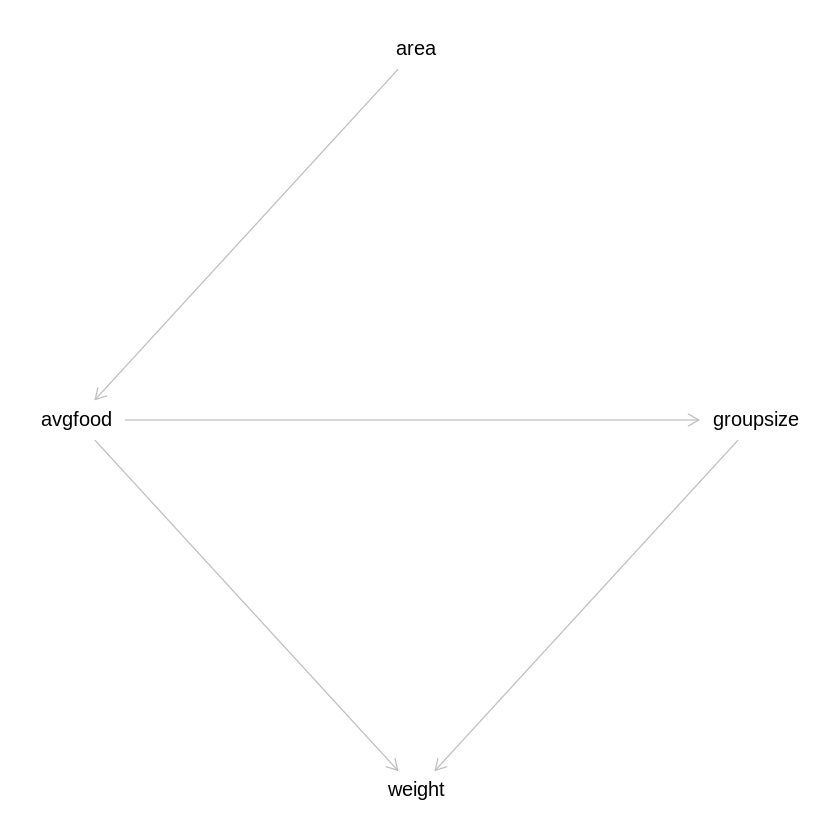

In [3]:
library(dagitty)

dag <- dagitty( "dag {
area -> avgfood
avgfood -> groupsize
avgfood -> weight
groupsize -> weight
}")

coordinates( dag ) <- list( x=c(area=1,avgfood=0,groupsize=2,weight=1) , y=c(area=0,avgfood=1,groupsize=1,weight=2) ) 

plot( dag )

In [4]:
impliedConditionalIndependencies( dag )

area _||_ groupsize | avgfood
area _||_ weight | avgfood

There exists a 'pipe' from area to weight through avgfood.  To avoid post-treatment bias, we do NOT want to control for avgfood.  Should we control for groupsize, since this will prevent the flow of information from avgfood to weight via groupsize? This is not necessary either, since there is no backdoor going from area to weight via groupsize.

In [5]:
mFoxSimple <- quap(
    alist(
    weight ~ dnorm( mu , sigma ),
    mu <- a + b_area*area,
    a ~ dnorm( 0 , 1 ),
    b_area ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(mFoxSimple,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,3.8581538,0.37127090,3.26479124,4.4515164
b_area,0.1971682,0.11295706,0.01664102,0.3776954
sigma,1.1842840,0.07848626,1.05884783,1.3097202


If we standardize the variables:

In [6]:
d$F <- scale( d$avgfood )
d$G <- scale( d$groupsize )
d$A <- scale( d$area )
d$W <- scale( d$weight )
head(d)

group,avgfood,groupsize,area,weight,F,G,A,W
<int>,<dbl>,<int>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,0.37,2,1.09,5.02,-1.924829,-1.524089,-2.239596,0.4141347
1,0.37,2,1.09,2.84,-1.924829,-1.524089,-2.239596,-1.4270464
2,0.53,2,2.05,5.33,-1.118035,-1.524089,-1.205508,0.6759540
2,0.53,2,2.05,6.07,-1.118035,-1.524089,-1.205508,1.3009421
3,0.49,2,2.12,5.85,-1.319734,-1.524089,-1.130106,1.1151348
3,0.49,2,2.12,3.25,-1.319734,-1.524089,-1.130106,-1.0807692


In [7]:
mFoxSimpleStandard <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_A*A,
    a ~ dnorm( 0 , 1 ),
    b_A ~ dnorm( 0 , 2 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(mFoxSimpleStandard,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-3.464162e-06,0.09164926,-0.1464767,0.1464697
b_A,1.943460e-02,0.09233733,-0.1281383,0.1670075
sigma,9.912646e-01,0.06466623,0.8879155,1.0946137


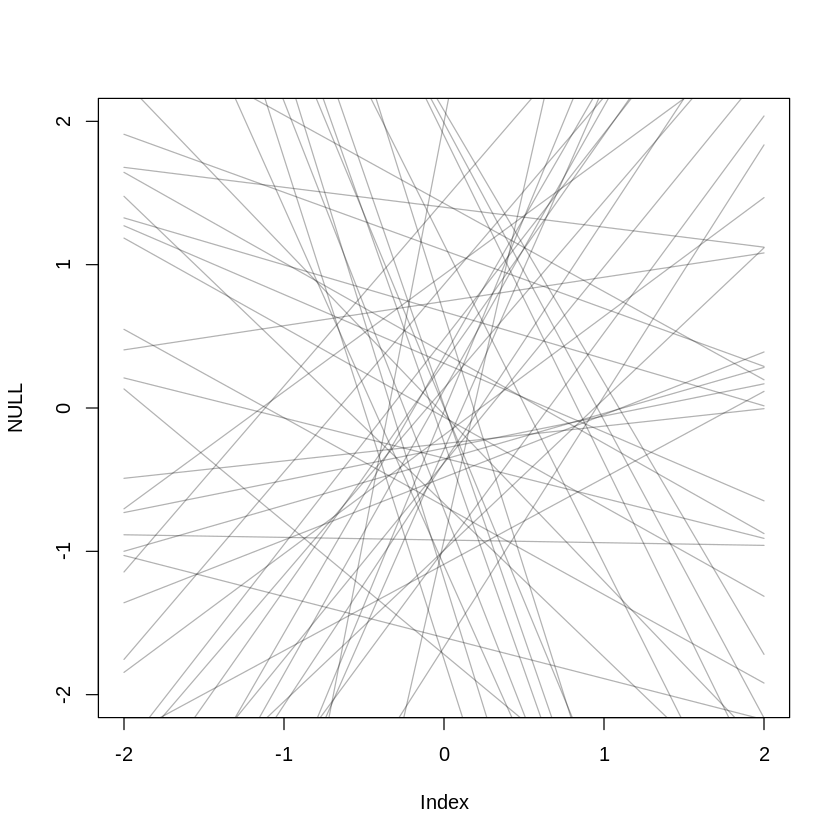

In [8]:
prior <- extract.prior( mFoxSimpleStandard )
xseq <- c(-2,2)
mu <- link( mFoxSimpleStandard , post=prior , data=list(A=xseq) )
plot( NULL , xlim=xseq , ylim=xseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.3) )

Following the advice in the book on pages 142-143, we adjust the priors to restrict the gradients to lower values:

In [9]:
mFoxSimple2Standard <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_A*A,
    a ~ dnorm( 0 , 0.2 ),
    b_A ~ dnorm( 0 , 0.5 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(mFoxSimple2Standard,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.894725e-08,0.08360867,-0.1336228,0.1336228
b_A,1.883362e-02,0.09089582,-0.1264355,0.1641027
sigma,9.912661e-01,0.06466649,0.8879166,1.0946157


Let's check the prior with prior predictive simulation again:

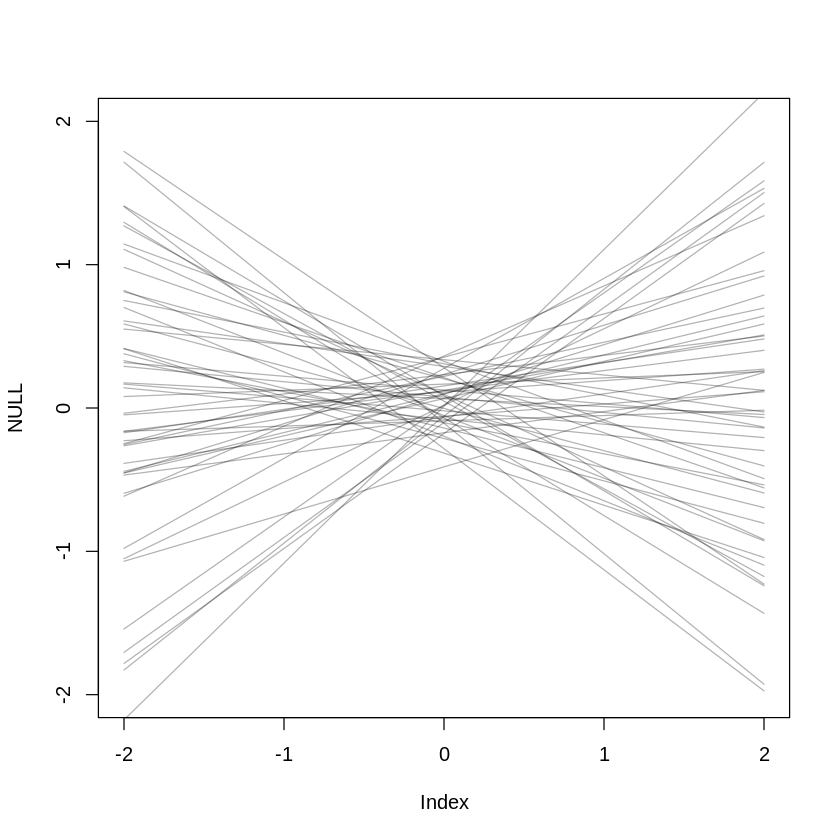

In [10]:
prior <- extract.prior( mFoxSimple2Standard )
xseq <- c(-2,2)
mu <- link( mFoxSimpleStandard , post=prior , data=list(A=xseq) )
plot( NULL , xlim=xseq , ylim=xseq )
for ( i in 1:50 ) lines( xseq , mu[i,] , col=col.alpha("black",0.3) )

2. Now infer the causal impact of adding food to a territory. Would this
make foxes heavier? Which covariates do you need to adjust for to estimate
the total causal influence of food?

We may think that adding food is likely to make foxes heavier, however this may also support a larger group size, which may negatively impact on weight.  From the solutions "To infer the causal influence of avgfood on weight, we need to close any back-door paths. There are no back-door paths in the DAG. So again, just use a model with a single predictor. If you include groupsize, to block the indirect path, then you won’t get the total causal influence of food. You’ll just get the direct influence. But I asked for the effect of adding food, and that would mean through all forward paths.

In [13]:
mFox2 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_F*F,
    a ~ dnorm( 0 , 0.2 ),
    b_F ~ dnorm( 0 , 0.5 ),
    sigma ~ dexp(1)
    ) , data=d )

precis(mFox2,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.194555e-07,0.08360017,-0.1336093,0.1336091
b_F,-2.421162e-02,0.09088502,-0.1694634,0.1210402
sigma,9.911440e-01,0.06465859,0.8878071,1.0944809


It appears adding food has no effect.

Question 3.

3. Now infer the causal impact of group size. Which covariates do you need
to adjust for? Looking at the posterior distribution of the resulting model,
what do you think explains these data? That is, can you explain the estimates
for all three problems? How do they go together?

We need to close the backdoor of the path via avgfood.  Avgfood is a confound, the source of a 'fork' in the DAG, so we need to control for it.

In [39]:
mFox3 <- quap(
    alist(
    W ~ dnorm( mu , sigma ),
    mu <- a + b_F*F + b_G*G,
    a ~ dnorm( 0 , 0.2 ),
    c(b_F,b_G) ~ dnorm(0,0.5),
    sigma ~ dexp(1)
    ) , data=d )

precis(mFox3,depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,2.478868e-08,0.08013807,-0.1280761,0.1280761
b_F,4.772533e-01,0.17912323,0.1909798,0.7635268
b_G,-5.735260e-01,0.17914172,-0.8598291,-0.2872229
sigma,9.420440e-01,0.06175256,0.8433515,1.0407365


So, as suspected, the group size appears to be negatively associated with weight.

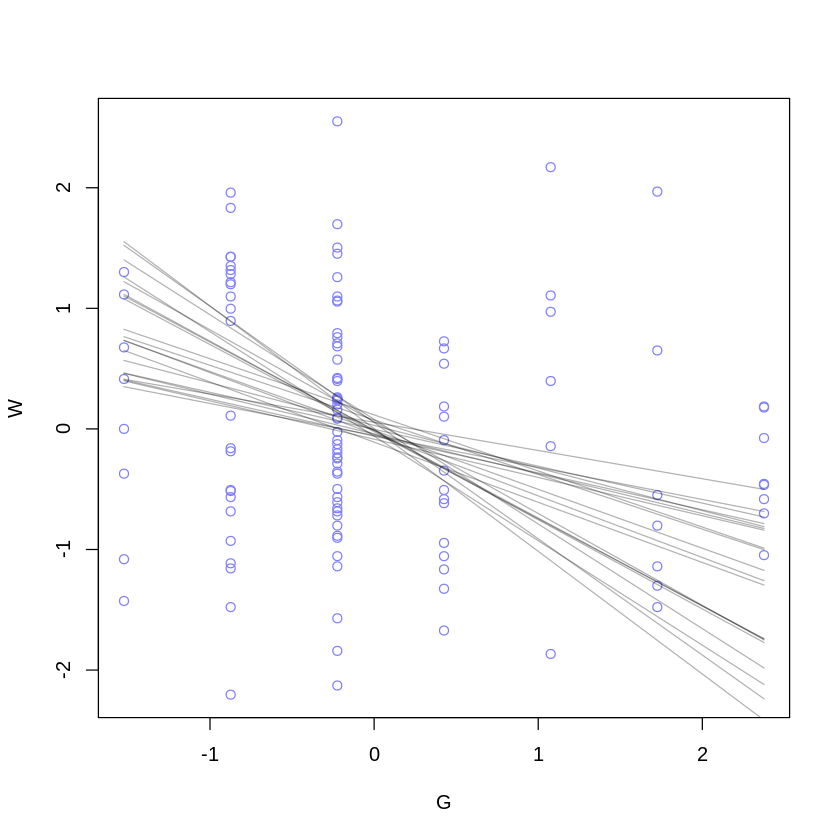

In [40]:
# extract 20 samples from the posterior
post <- extract.samples( mFox3 , n=20 )

# display raw data and sample size
plot( d$G, d$W ,
xlim=range(d$G) , ylim=range(d$W) ,
col=rangi2 , xlab="G" , ylab="W" )
#mtext(concat("N = ",N))
# plot the lines, with transparency

for ( i in 1:20 )
    curve( post$a[i] + post$b_G[i]*x , col=col.alpha("black",0.3) , add=TRUE )